# Week 11

# Agenda

1.  Neural Network with 1 Hidden Layer
2.  Neural Network with 2 Hidden Layer
3.  Regression with Neural Network

## Libraries Used

In [2]:
library(tidyverse)
library(torch)
library(glmnet)
library(caret)
library(dplyr)
library(tidyr)
library(dplyr)
library(nnet)
library(mlbench)
library(class)
library(rpart.plot)
library(e1071)

Loading required package: Matrix


Attaching package: 'Matrix'


The following objects are masked from 'package:tidyr':

    expand, pack, unpack


Loaded glmnet 4.1-4

Loading required package: lattice


Attaching package: 'caret'


The following object is masked from 'package:purrr':

    lift


Loading required package: rpart



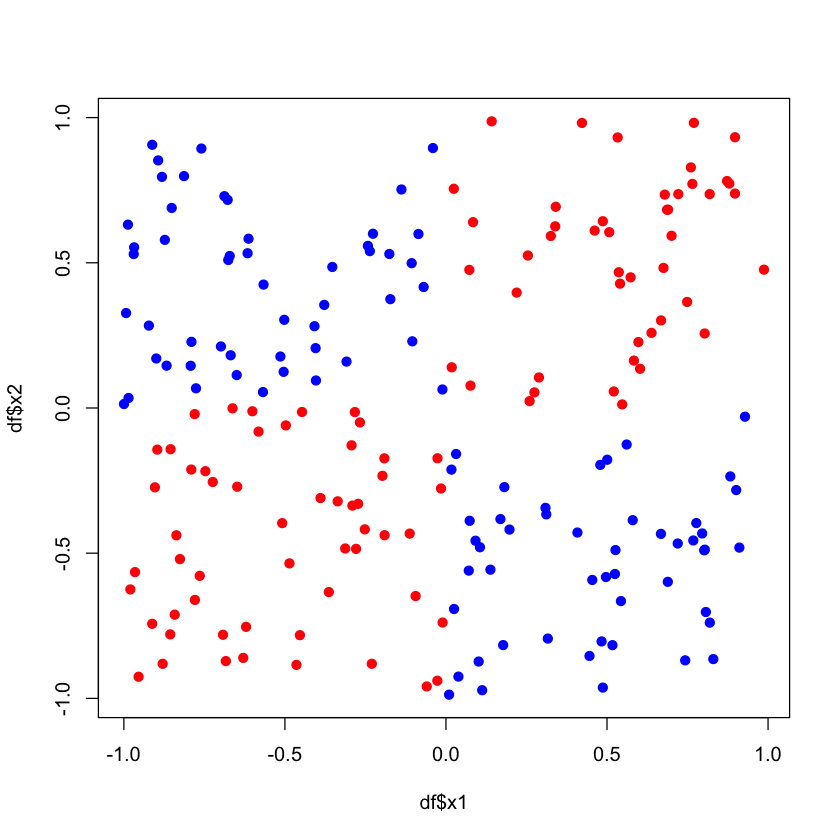

In [7]:
ex1 <- \(x)ifelse(
sign(x[ 1 ]* x[ 2 ]) +0.01 *rnorm( 1 ) <= 0 , 0 , 1 )
n<- 200
X<- t(replicate(n, 2 *runif( 2 ) - 1 ))
y<- apply(X, 1 , ex1) %>% as.factor()
col <- ifelse(y == 0 , 'blue','red')
df <- data.frame(y = y, x1 = X[, 1 ], x2 =X[, 2 ])
plot(df$x1, df$x2,col = col,pch = 19 )

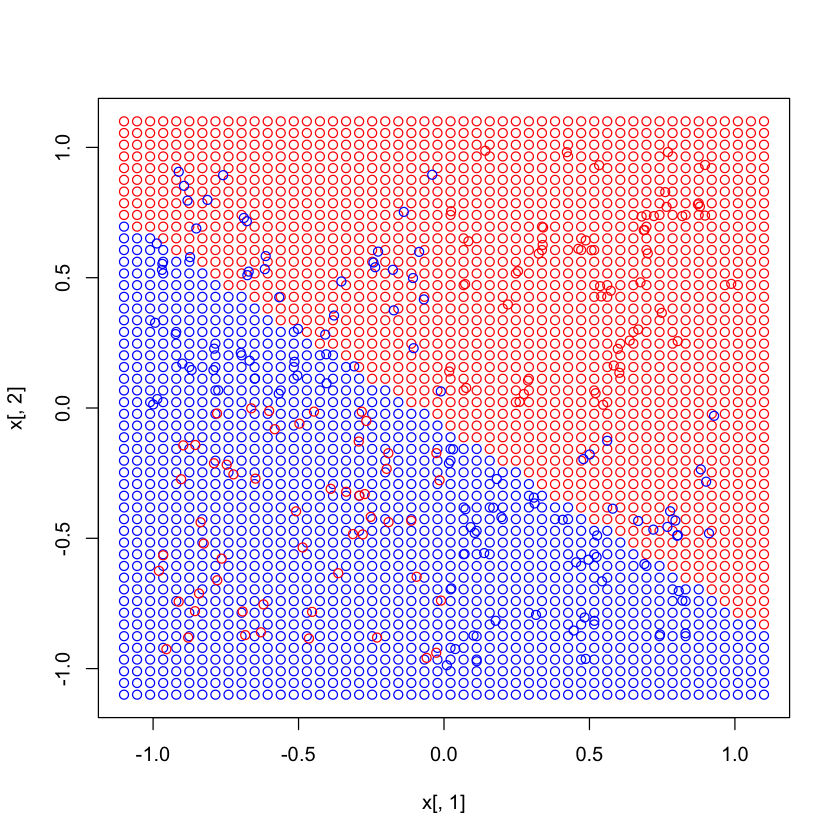

In [9]:
model <- glm(y~. , df, family = binomial())
plt <- function(f, x){
    plot(x[,1], x[,2], col = ifelse(f(x) < 0.5, "blue", "red"))
    points(df$x1, df$x2, col = ifelse(y == "0", "blue", "red"))
}
x1 = rep(seq(-1.1, 1.1, length.out = 50), 50)
x2 = rep(seq(-1.1, 1.1, length.out = 50), each = 50)
x_new = cbind(x1, x2)

f_logit = \(x) predict(model, data.frame(x1 = x[,1], x2 = x[,2]), type = "response")

plt(f_logit, x_new)



In [10]:
overview <- function(f){
    predicted <- ifelse(f(df[,-1]) <0.5, 0, 1)
    actual <- df[,1]
    table(predicted, actual)
}
overview(f_logit)

         actual
predicted  0  1
        0 54 54
        1 46 46

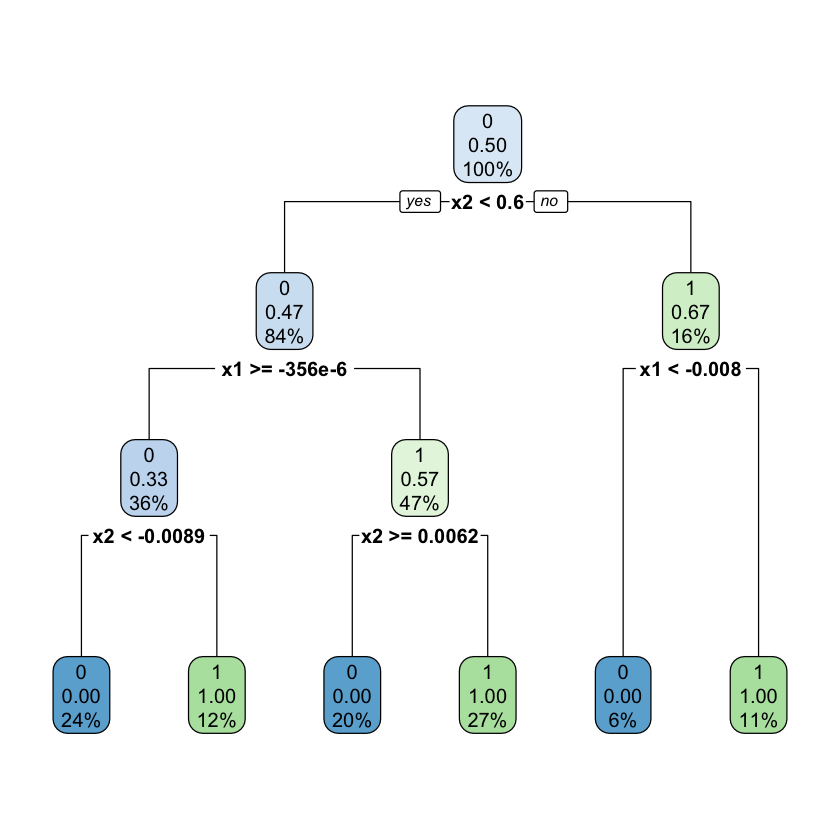

In [12]:
dtree <- rpart(y~x1 + x2,df, method = "class")
rpart.plot(dtree)

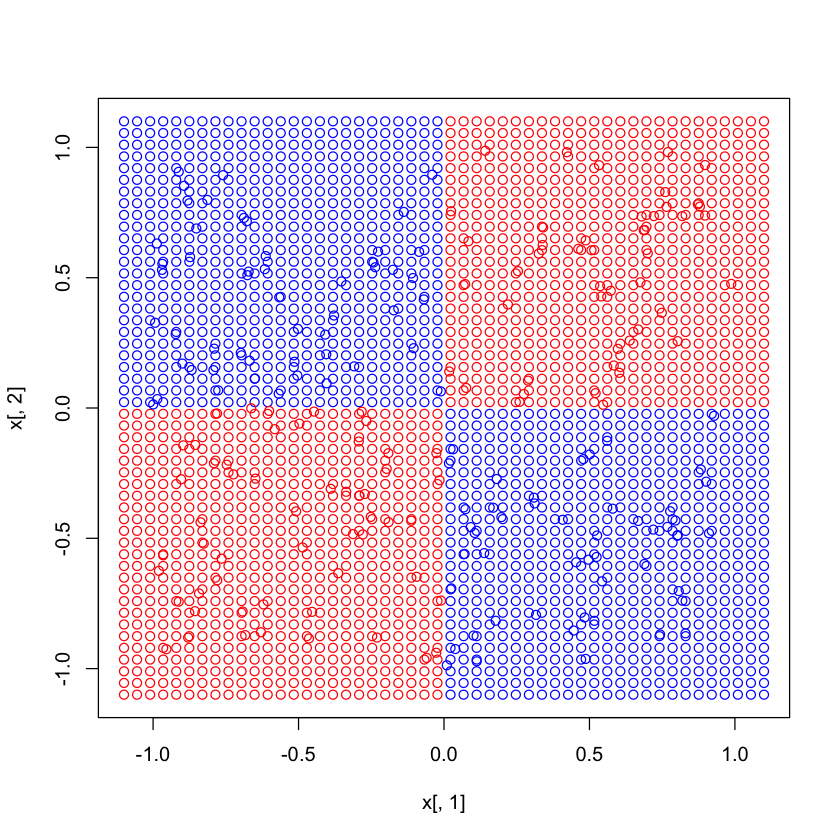

In [14]:
f_dtree <- \(x) as.numeric(predict(dtree, data.frame(x1 = x[,1], x2 = x[,2]), type="class")) - 1
plt(f_dtree, x_new)


In [16]:
overview(f_dtree)

         actual
predicted   0   1
        0 100   0
        1   0 100

## Neural Network with 1 Hidden Layer

Input layer: 2 neurons 
Hidden layer: 20 neurons with a linear activation
function (nn_linear) 
Output layer: 1 neuron with a linear activation
function (nn_linear) 
Activation function after the hidden layer:
Rectified Linear Unit (ReLU) - nn_relu Activation function after the
output layer: Sigmoid - nn_sigmoid

In [18]:
x_tensor <- torch_tensor(df[,-1] %>% as.matrix(), dtype = torch_float())
y_tensor <- torch_tensor(cbind(df[,1] %>% as.numeric() - 1), dtype = torch_float())

Loss<- function(x, y, model){
    nn_bce_loss()(model(x), y)
}

x1 = rep(seq(-1.1, 1.1, length.out = 50), 50)
x2 = rep(seq(-1.1, 1.1, length.out = 50), each = 50)
x_new = cbind(x1, x2)

df_new <- data.frame(x1 = x_new[,1], x2 = x_new[,2])


module <- nn_module(
    initialize = function() {
        self$f <- nn_linear(2, 20)
        self$g <- nn_linear(20, 1)
        self$a <- nn_relu()
        self$s <- nn_sigmoid()
    },
    forward = function(x){
        x %>% self$f() %>% 
        self$a() %>% 
        self$g() %>%
        self$a() %>%
        self$s()

    }
)

In [19]:
F <- module()
Loss(x_tensor, y_tensor, F)

torch_tensor
0.698627
[ CPUFloatType{} ][ grad_fn = <BinaryCrossEntropyBackward0> ]

In [21]:
optimizer <- optim_adam(F$parameters, lr = 0.05)
epochs <- 1000
for(i in 1 :epochs){
    loss <- Loss(x_tensor, y_tensor, F)
    optimizer$zero_grad()
    loss$backward()
    optimizer$step()
    if (i < 10 || i %% 100 == 0 ) {
    cat(sprintf("Epoch: %d, Loss: %.4f\n", i, loss$item()))
    }
}

Epoch: 1, Loss: 0.6986
Epoch: 2, Loss: 0.6768
Epoch: 3, Loss: 0.6666
Epoch: 4, Loss: 0.6518
Epoch: 5, Loss: 0.6401
Epoch: 6, Loss: 0.6310
Epoch: 7, Loss: 0.6234
Epoch: 8, Loss: 0.6159
Epoch: 9, Loss: 0.6092
Epoch: 100, Loss: 0.5384
Epoch: 200, Loss: 0.5354
Epoch: 300, Loss: 0.5345
Epoch: 400, Loss: 0.5345
Epoch: 500, Loss: 0.5341
Epoch: 600, Loss: 0.5345
Epoch: 700, Loss: 0.5339
Epoch: 800, Loss: 0.5339
Epoch: 900, Loss: 0.5338
Epoch: 1000, Loss: 0.5338


In [22]:
f_nn = \(x) as_array(F(torch_tensor(x %>% as.matrix(), dtype = torch_float())))
overview(f_nn)

         actual
predicted   0   1
        1 100 100

**Neural Network with 2 hidden layer**

**Regression with Neural Networks**